<a href="https://colab.research.google.com/github/rohitm487/Causal_Inference_in_Python/blob/main/2_Causal_Inference_Regression_discontinuity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Lead_Score  Customer_Spend  Add_Support  Counterfactual
0    0.000000      212.417854            0      200.000000
1    0.502513      197.548418            0      201.005025
2    1.005025      218.202264            0      202.010050
3    1.507538      241.090822            0      203.015075
4    2.010050      198.166266            0      204.020101


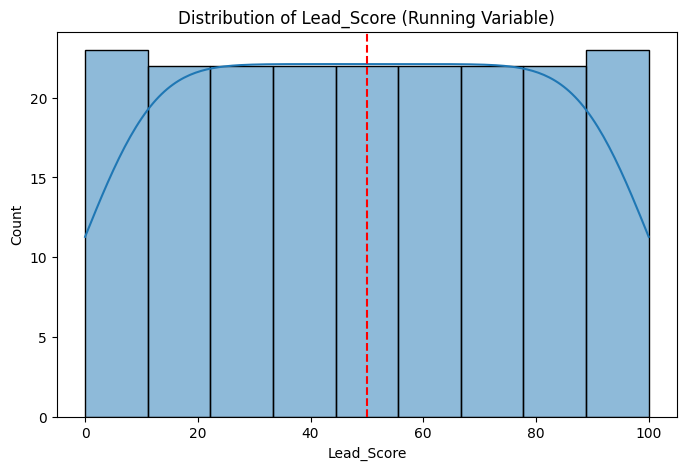

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde

# Simulate a dataset
def sim_reg_discontinuity_df():
    np.random.seed(42)
    n = 200
    Lead_Score = np.linspace(0, 100, n)
    Add_Support = (Lead_Score >= 50).astype(int)  # Indicator for cutoff at 50
    Counterfactual = 200 + Lead_Score * 2  # Baseline linear trend
    Customer_Spend = Counterfactual + Add_Support * 50 + np.random.normal(0, 25, n)  # Add discontinuity effect
    return pd.DataFrame({
        'Lead_Score': Lead_Score,
        'Customer_Spend': Customer_Spend,
        'Add_Support': Add_Support,
        'Counterfactual': Counterfactual
    })

# Generate the data
dat = sim_reg_discontinuity_df()

# Explore the data
print(dat.head())

# 1. Plotting the distribution of Lead_Score to check continuity around cutoff
plt.figure(figsize=(8, 5))
sns.histplot(dat['Lead_Score'], kde=True)
plt.axvline(x=50, color='red', linestyle='--', label='Cutoff at 50')
plt.title("Distribution of Lead_Score (Running Variable)")
plt.show()


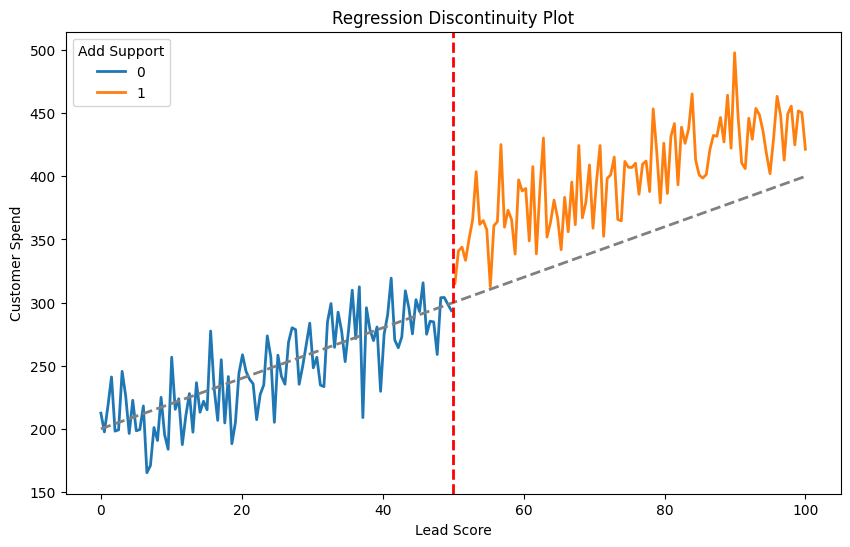

In [5]:

# 2. Regression discontinuity plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Lead_Score', y='Customer_Spend', hue='Add_Support', data=dat, linewidth=2)
sns.lineplot(x='Lead_Score', y='Counterfactual', data=dat, linestyle='--', linewidth=2, color='gray')
plt.axvline(x=50, linestyle='--', linewidth=2, color='red')  # cutoff at Lead_Score=50
plt.xlabel("Lead Score")
plt.ylabel("Customer Spend")
plt.title("Regression Discontinuity Plot")
plt.legend(title="Add Support", loc="upper left")
plt.show()


In [6]:

# 3. Fit regression discontinuity model
model = ols('Customer_Spend ~ Lead_Score + Add_Support + Lead_Score:Add_Support', data=dat).fit()

# 4. Summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         Customer_Spend   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     826.2
Date:                Fri, 11 Oct 2024   Prob (F-statistic):          6.38e-111
Time:                        06:55:52   Log-Likelihood:                -912.20
No. Observations:                 200   AIC:                             1832.
Df Residuals:                     196   BIC:                             1846.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                195

In [7]:

# 5. Causal impact: difference in regression lines at the cutoff (Lead_Score = 50)
lead_score_at_cutoff = 50
add_support_at_cutoff = 1
predicted_with_support = (
    model.params['Intercept'] + model.params['Lead_Score'] * lead_score_at_cutoff +
    model.params['Add_Support'] + model.params['Lead_Score:Add_Support'] * lead_score_at_cutoff
)


In [8]:
predicted_without_support = (
    model.params['Intercept'] + model.params['Lead_Score'] * lead_score_at_cutoff
)

causal_impact = predicted_with_support - predicted_without_support
print(f"Causal impact at cutoff (Lead_Score = 50): {causal_impact:.2f}")


Causal impact at cutoff (Lead_Score = 50): 51.16


In [9]:

# 6. Add bandwidth analysis: focus on data around the cutoff (e.g., within 10 points)
bandwidth = 10
dat_bandwidth = dat[(dat['Lead_Score'] >= (50 - bandwidth)) & (dat['Lead_Score'] <= (50 + bandwidth))]

# Refit the model with restricted bandwidth
model_bandwidth = ols('Customer_Spend ~ Lead_Score + Add_Support + Lead_Score:Add_Support', data=dat_bandwidth).fit()
print(model_bandwidth.summary())


                            OLS Regression Results                            
Dep. Variable:         Customer_Spend   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     39.17
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           1.98e-11
Time:                        06:55:58   Log-Likelihood:                -177.63
No. Observations:                  40   AIC:                             363.3
Df Residuals:                      36   BIC:                             370.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                249

In [10]:

# Causal impact within the bandwidth
predicted_with_support_bw = (
    model_bandwidth.params['Intercept'] + model_bandwidth.params['Lead_Score'] * lead_score_at_cutoff +
    model_bandwidth.params['Add_Support'] + model_bandwidth.params['Lead_Score:Add_Support'] * lead_score_at_cutoff
)
predicted_without_support_bw = (
    model_bandwidth.params['Intercept'] + model_bandwidth.params['Lead_Score'] * lead_score_at_cutoff
)

causal_impact_bw = predicted_with_support_bw - predicted_without_support_bw
print(f"Causal impact at cutoff (within bandwidth): {causal_impact_bw:.2f}")


Causal impact at cutoff (within bandwidth): 44.95


1. Clarifying the Threshold and Running Variable:
In RDD, it's crucial to explicitly define the running variable (here, Lead_Score) and the cutoff (which is implicitly set at Lead_Score = 50). These should be made clear to ensure the causal inference framework is understood.

Refinement: Explicitly highlight the cutoff, ensure it's treated as a discontinuity point, and explain the assumptions.

2. Checking Assumptions for RDD:
RDD assumes that units just above and below the cutoff are comparable. In practice, you should always check:

Continuity of the running variable (smooth distribution around the cutoff).
No other structural breaks or manipulations near the cutoff (e.g., other unobserved variables shifting at the threshold).
Refinement: Add checks to ensure that the Lead_Score variable is continuous around the cutoff.

3. Bandwidth Selection:
In RDD, observations close to the cutoff typically provide the most valid causal estimates. However, observations far from the cutoff may distort the estimate due to different trends in the data. A common practice is to restrict the analysis to a bandwidth around the cutoff (i.e., focus only on observations within a specific range).

Refinement: Implement a local linear regression near the cutoff using a bandwidth selection method (like rdrobust or a similar approach).

4. Non-parametric Estimation:
While the parametric model (lm in R or ols in Python) works, non-parametric methods can sometimes offer a more flexible estimation of treatment effects, especially near the cutoff.

Refinement: For a more robust estimate, consider using non-parametric methods or running local linear regressions at the cutoff.

5. Covariates:
Including additional covariates can help control for potential confounders if the dataset is more complex than what we've simulated.